# Example of upper limit computation.

In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import zfit
from utils import plotfitresult, plotlimit, pltdist
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

# from hepstats.hypotests import UpperLimit
# from hepstats.hypotests.calculators import AsymptoticCalculator
# from hepstats.hypotests.parameters import POI, POIarray

In [3]:
plt.rcParams["figure.figsize"] = (9, 8)
plt.rcParams["font.size"] = 16

### Fit of a Gaussian signal over an exponential background:

In [4]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1 / tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 10)
data = np.concatenate((data, peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

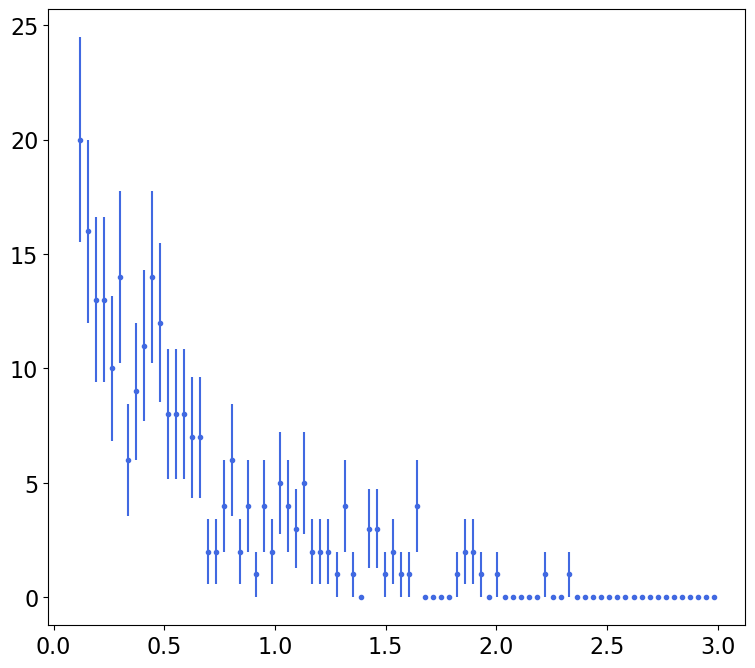

In [5]:
pltdist(data, bins=80, bounds=bounds)

In [6]:
data.size

256

In [7]:
obs = zfit.Space("x", limits=bounds)

In [8]:
lambda_ = zfit.Parameter("lambda", -2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Nsig", 1.0, -20.0, len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0.0, len(data) * 1.1)

In [9]:
signal = zfit.pdf.Gauss(obs=obs, mu=1.2, sigma=0.1).create_extended(Nsig)
background = zfit.pdf.Exponential(obs=obs, lambda_=lambda_).create_extended(Nbkg)
tot_model = zfit.pdf.SumPDF([signal, background])

In [10]:
# Create the negative log likelihood
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=tot_model, data=data_)

In [11]:
# Instantiate a minuit minimizer
minimizer = Minuit()

In [12]:
# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)
minimum.hesse()

{<zfit.Parameter 'Nsig' floating=True value=4.527>: {'error': 5.757298759948026,
  'cl': 0.683,
  'weightcorr': <WeightCorr.FALSE: False>},
 <zfit.Parameter 'Nbkg' floating=True value=251.6>: {'error': 16.762202460033812,
  'cl': 0.683,
  'weightcorr': <WeightCorr.FALSE: False>},
 <zfit.Parameter 'lambda' floating=True value=-1.93>: {'error': 0.13984759778575204,
  'cl': 0.683,
  'weightcorr': <WeightCorr.FALSE: False>}}

Text(0, 0.5, 'number of events')

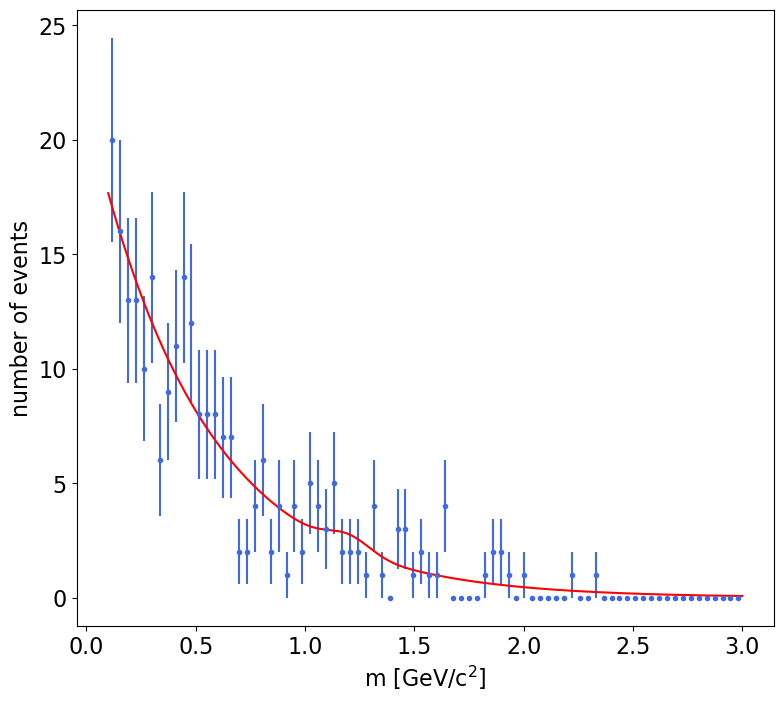

In [13]:
nbins = 80
pltdist(data, nbins, bounds)
plotfitresult(tot_model, bounds, nbins)
plt.xlabel("m [GeV/c$^2$]")
plt.ylabel("number of events")

### Upper limit:

Since the signal yield Nsig = $4.5 \pm 5.8$  is consistent with zero signal we compute the CLs upper limit at 95% confidence level on Nsig.

In [ ]:
# instantation of the calculator
calculator = AsymptoticCalculator(nll, minimizer)
calculator.bestfit = minimum  # optionnal

In [ ]:
# parameter of interest of the null hypothesis
poinull = POIarray(Nsig, np.linspace(0.0, 25, 20))
# parameter of interest of the alternative hypothesis
poialt = POI(Nsig, 0)

In [ ]:
# instantation of the discovery test
ul = UpperLimit(calculator, poinull, poialt)

In [ ]:
ul.upperlimit(alpha=0.05, CLs=True);

In [ ]:
f = plt.figure(figsize=(9, 8))
plotlimit(ul, alpha=0.05, CLs=True)
plt.xlabel("Nsig")
f.savefig("asy_ul.png")

In [ ]:
f = plt.figure(figsize=(9, 8))
plotlimit(ul, alpha=0.05, CLs=False)